Примение transfer learning и fine-tuning для  задачи классификации кошек и собак.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 100
IMG_SHAPE  = 150 

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

68616192/68606236 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
IMG_SHAPE = (150, 150, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False 

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Сеть готова для обучения.

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

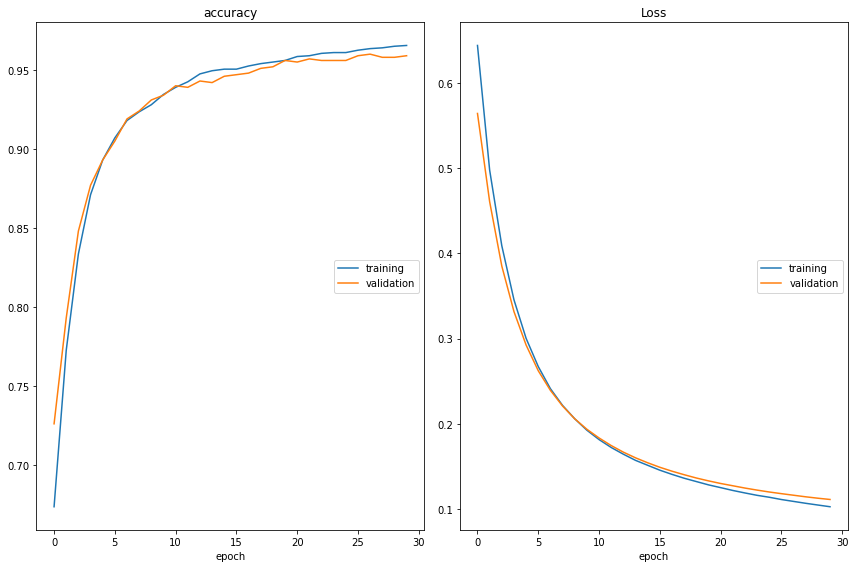

accuracy
	training         	 (min:    0.674, max:    0.965, cur:    0.965)
	validation       	 (min:    0.726, max:    0.960, cur:    0.959)
Loss
	training         	 (min:    0.103, max:    0.644, cur:    0.103)
	validation       	 (min:    0.111, max:    0.564, cur:    0.111)
20/20 [==============================] - 9s 469ms/step - loss: 0.1025 - accuracy: 0.9655 - val_loss: 0.1110 - val_accuracy: 0.9590


In [ ]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

С помощью transfer learning добились точности на валидации в 95,9%. Теперь дообучим сеть разморозив слои базовой модели и обучим заново.

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

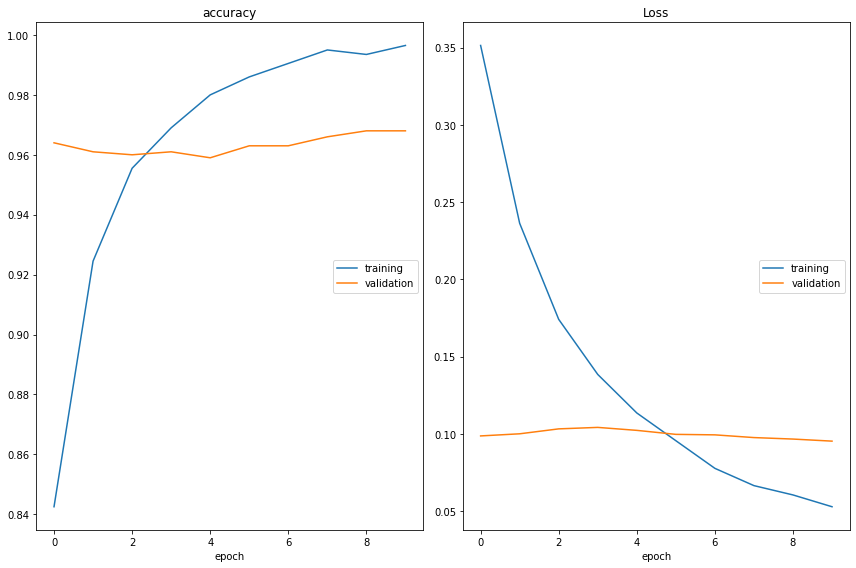

accuracy
	training         	 (min:    0.842, max:    0.997, cur:    0.997)
	validation       	 (min:    0.959, max:    0.968, cur:    0.968)
Loss
	training         	 (min:    0.053, max:    0.351, cur:    0.053)
	validation       	 (min:    0.095, max:    0.104, cur:    0.095)
20/20 [==============================] - 9s 470ms/step - loss: 0.0528 - accuracy: 0.9965 - val_loss: 0.0953 - val_accuracy: 0.9680


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

После обучения точность увеличилась 96,8% , но видны небольшие признаки переобучения на тренировочных данных (точность 99,6%). Посмотрим реальный и предсказанный класс для изображений.

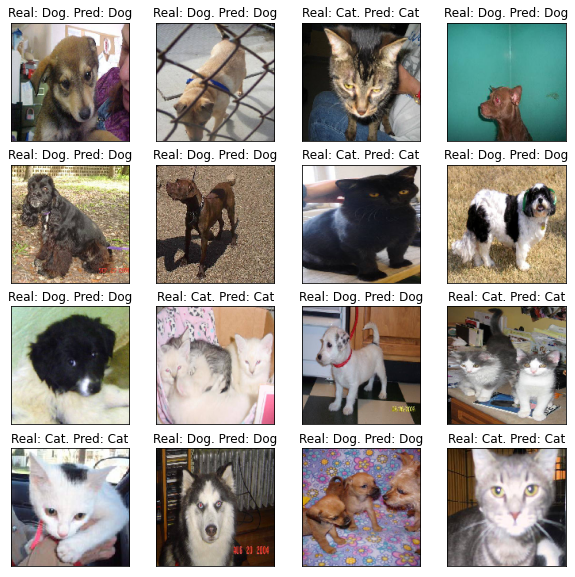

In [ ]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = (model.predict(sample_validation_images) > 0.5).astype("int32").flatten()


show_catsdogs(sample_validation_images, sample_validation_labels, predicted)